In [1]:
import polars as pl
import numpy as np
from utils import Donation
from scipy.optimize import minimize
from scipy.special import gammaln, comb, hyp2f1
from scipy.special import beta as beta_fn
from scipy.stats import beta as beta_dist
from scipy.integrate import quad

import altair as alt
import matplotlib.pyplot as plt
import matplotlib_inline
from IPython.display import display_markdown

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

**Source**: 
- [Customer-Base Analysis in a Discrete-Time Noncontractual Setting](http://www.brucehardie.com/papers/020/)
- [Implementing the BG/BB Model for Customer-Base Analysis in Excel](http://www.brucehardie.com/notes/010/)
- [Implementing the $S_{BB}-G/B$ Model in MATLAB](http://www.brucehardie.com/notes/023/)

In [2]:
data = Donation()
rfm_summary_calib = data.p1x_data()
rfm_array_calib = rfm_summary_calib.collect().to_numpy()
rfm_summary_valid = data.p2x_data()
p1x, t_x, _, num_donors = [*rfm_array_calib.T]

n = 6
n * (n + 1)/2 + 1 # Possible recency/frequency patterns in calibration period
years = data.years

In [3]:
def rfcalib_cross_tab(df, values, title, subtitle=None, color_range=[0,1]):
    tx_year_map = {tx: int(year) for tx, year in enumerate(years)}
    
    return (
        df
        .with_columns(pl.col("t_x").replace(tx_year_map).alias("Year"))
        .sort('Year')
        .pivot(on='Year', index='P1X', values=values)
        .sort('P1X')
        .style.tab_header(title=title, subtitle=subtitle)
        .tab_stub(rowname_col="P1X")
        .tab_stubhead(label='P1X')
        .fmt_number(decimals=2)   
        .tab_spanner(
            label="Year of last transaction",
            columns=years[:7]
        ).data_color(
            domain=color_range,
            palette=["white", "rebeccapurple"],
            na_color="white",
        ).sub_missing(
            columns=pl.col('*'),
            missing_text=""
        )            
    )

### Parameter Estimation

In [4]:
def bgbb_est(rfm_data, guess={'alpha': 1, 'beta': 0.5, 'gamma': 0.5, 'delta': 2.5}):
    p1x, t_x, n, num_donors = [*rfm_data.T]

    def log_likelihood(param):
        alpha, beta, gamma, delta = param
        B_alpha_beta = beta_fn(alpha, beta)
        B_gamma_delta = beta_fn(gamma, delta)
        
        A1 = beta_fn(alpha+p1x,beta+n-p1x)/B_alpha_beta * \
                 beta_fn(gamma,delta+n)/B_gamma_delta
        i = np.arange(6).reshape(-1,1)
        A2 = beta_fn(alpha+p1x, beta+t_x-p1x+i)/B_alpha_beta* \
                  beta_fn(gamma+1, delta+t_x+i)/B_gamma_delta        
        A2 = np.where(i <=  (n - t_x - 1), A2, 0)

        return -np.sum(num_donors * np.log(A1 + np.sum(A2, axis=0)))
    
    bnds = [[0, np.inf] for _ in range(4)]
    return minimize(log_likelihood, x0=list(guess.values()), bounds=bnds)

# Sample parameters
# alpha = 1.20352083040498
# beta = 0.749714243061896
# gamma = 0.656712169147878
# delta = 2.78340801635898

res = bgbb_est(rfm_array_calib)
alpha, beta, gamma, delta = res.x
ll = res.fun

display_markdown(f'''$\\alpha$ = {alpha:0.4f}

$\\beta$ = {beta:0.4f}

$\\gamma$ = {gamma:0.4f}

$\\delta$ = {delta:0.4f}

Log-Likelihood = {-ll:0.4f}''', raw=True)

$\alpha$ = 1.2035

$\beta$ = 0.7497

$\gamma$ = 0.6568

$\delta$ = 2.7839

Log-Likelihood = -33225.5813

### Likelihood Function

Likelihood function for a randomly chosen customer with purchase history ($x, t_{x}, n$)

In [5]:
B_alpha_beta = beta_fn(alpha, beta)
B_gamma_delta = beta_fn(gamma, delta)

A1 = beta_fn(alpha+p1x, beta+n-p1x)/B_alpha_beta * beta_fn(gamma, delta+n)/B_gamma_delta
i = np.arange(6).reshape(-1,1)
A1a = beta_fn(alpha+p1x, beta+t_x-p1x+i)/B_alpha_beta * beta_fn(gamma+1, delta+t_x+i)/B_gamma_delta  
A1a = np.where(i <= (n - t_x - 1), A1a, 0)
L = A1 + np.sum(A1a, axis=0)

L_df = rfm_summary_calib.collect().hstack([pl.Series('Likelihood', L)])

### In-Sample Model Fit Plot

In [6]:
x = np.arange(n+1)
A1 = comb(n,x)*beta_fn(alpha+x, beta+n-x)/B_alpha_beta*beta_fn(gamma, delta+n)/B_gamma_delta 
i = np.arange(n).reshape(-1,1)
A2 = comb(i,x)*beta_fn(alpha+x, beta+i-x)/B_alpha_beta * beta_fn(gamma+1, delta+i)/B_gamma_delta
P_X_n = A1 + np.sum(A2,axis=0)

model_repeat_calib = pl.DataFrame({'Model': P_X_n * np.sum(rfm_array_calib[:,3])})

actual_model_repeat_calib = (
    rfm_summary_calib
    .group_by('P1X')
    .agg((pl.col('Count').sum()).alias('Actual'))
    .sort('P1X')
    .collect()
    .hstack(model_repeat_calib)
    .unpivot(on=['Actual', 'Model'], index='P1X', value_name='No of people', variable_name='Actual Vs Estimated')
)

(
    alt.Chart(actual_model_repeat_calib).mark_bar()
    .encode(x=alt.X('P1X:O', title='No. of repeat transactions', axis=alt.Axis(labelAngle=0)), 
         y=alt.Y('No of people:Q', title='No. of people'), 
         color='Actual Vs Estimated:N', 
         xOffset='Actual Vs Estimated')
    .properties(
        width=650,
        height=250,
        title='Predicted vs. Actual Frequency of Repeat Transactions (Calibration Period) in 1996 to 2001'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)   
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Calibration Period Model Fit Plot

In [7]:
n_star = 5
x_star = np.arange(n_star+1)

A1 = comb(n_star,x_star)*beta_fn(alpha+x_star, beta+n_star-x_star)/B_alpha_beta * beta_fn(gamma, delta+n+n_star)/B_gamma_delta
A1 += np.where(x_star == 0, 1 - beta_fn(gamma, delta+n)/B_gamma_delta, 0)
i = np.arange(n_star).reshape(-1,1)
A2 = comb(i,x_star)*beta_fn(alpha+x_star, beta+i-x_star)/B_alpha_beta * beta_fn(gamma+1, delta+n+i)/B_gamma_delta
P_X_n_star = A1 + np.sum(A2, axis=0)

valid_repeat_count = rfm_summary_valid.collect().to_numpy()[:,2]
model_repeat_valid = pl.DataFrame({'Model': P_X_n_star * np.sum(valid_repeat_count)})

actual_model_repeat_valid = (
    rfm_summary_valid
    .group_by('P2X')
    .agg((pl.col('Count').sum()).alias('Actual'))
    .sort('P2X')
    .collect()
    .hstack(model_repeat_valid)
    .unpivot(on=['Actual', 'Model'], index='P2X', value_name='No of people', variable_name='Actual Vs Estimated')
)

(
    alt.Chart(actual_model_repeat_valid).mark_bar()
    .encode(x=alt.X('P2X:O', title='No. of repeat transactions', axis=alt.Axis(labelAngle=0)), 
         y=alt.Y('No of people:Q', title='No. of people'), 
         color='Actual Vs Estimated:N', 
         xOffset='Actual Vs Estimated')
    .properties(
        width=650,
        height=250,
        title='Predicted vs. Actual Frequency of Repeat Transactions (Validation Period) in 2002-2006'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)   
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Tracking Plots

In [8]:
act_yearly_repeat = data.data.select(pl.col('*').exclude('ID', '1995')).sum().collect().to_numpy()
act_cum_repeat = act_yearly_repeat.cumsum()

A1 = alpha / (alpha + beta)
A2 = 1/(gamma-1)
n_trans = np.arange(1, len(years))
A3 = np.exp(gammaln(delta+n_trans+1)+gammaln(gamma+delta)-gammaln(delta)-gammaln(gamma+delta+n_trans))
E_X_n = A1 * (delta*A2-A2*A3)

est_cum_repeat = np.sum(rfm_array_calib[:,3]) * E_X_n
est_yearly_repeat = np.diff(est_cum_repeat, prepend=0)

yearly_repeat = pl.DataFrame({'Year': years[1:], 'Actual': act_yearly_repeat.flatten(), 'Model': est_yearly_repeat.flatten()})
yearly_repeat = yearly_repeat.unpivot(on=['Actual', 'Model'], index='Year', variable_name='Actual Vs Model', value_name='Repeat Trans')
cum_repeat = pl.DataFrame({'Year': years[1:], 'Actual': act_cum_repeat.flatten(), 'Model': est_cum_repeat.flatten()})
cum_repeat = cum_repeat.unpivot(on=['Actual', 'Model'], index='Year', variable_name='Actual Vs Model', value_name='Repeat Trans')

(
    alt.Chart(yearly_repeat).mark_line().encode(
        x=alt.X('Year', axis=alt.Axis(labelAngle=0)),
        y=alt.Y('Repeat Trans', title='No. of repeat transactions'),
        strokeDash='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Annual Repeat Transactions'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [9]:
(
    alt.Chart(yearly_repeat).mark_bar().encode(
        x=alt.X('Year', axis=alt.Axis(labelAngle=0)),
        y=alt.Y('Repeat Trans', title='No. of repeat transactions'),
        color='Actual Vs Model',
        xOffset='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Annual Repeat Transactions'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [10]:
(
    alt.Chart(cum_repeat).mark_line().encode(
        x=alt.X('Year', axis=alt.Axis(labelAngle=0)),
        y=alt.Y('Repeat Trans', title='Cumulative no. of repeat transactions'),
        strokeDash='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Cumulative Repeat Transactions'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [11]:
(
    alt.Chart(cum_repeat).mark_bar().encode(
        x=alt.X('Year', axis=alt.Axis(labelAngle=0)),
        y=alt.Y('Repeat Trans', title='Cumulative no. of repeat transactions'),
        color='Actual Vs Model',
        xOffset='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Cumulative Repeat Transactions'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Conditional Expectations

In [12]:
n_star = 5

A2 = beta_fn(alpha+p1x+1, beta+n-p1x)/B_alpha_beta
A3 = delta/(gamma-1)*np.exp(gammaln(gamma+delta)-gammaln(delta+1))*(np.exp(gammaln(1+delta+n)-\
     gammaln(gamma+delta+n))-np.exp(gammaln(1+delta+n+n_star)-gammaln(gamma+delta+n+n_star)))

ce = A2 * A3 / L

exp_total = ce * num_donors

ce_df = (
    data.rfm_data()
    .group_by('P1X', 't_x', 'np1x')
    .agg(pl.col('P2X').sum().alias('Actual Total - Valid'))
    .sort(['t_x', 'P1X'], descending=True)
    .collect()
    .hstack([pl.Series('Exp Total', exp_total)])
    .hstack([pl.Series('Conditional Expectation', ce)])
)

# Actual total 2002-2006 donations by p1x / tx
actual_ce_mat = ce_df.sort('t_x').pivot(index='P1X', on='t_x', values='Actual Total - Valid').sort('P1X').fill_null(0).to_numpy()
p1x_frequency = actual_ce_mat[:,0]
actual_ce_mat = actual_ce_mat[:,1:]

# Expected total 2002-2006 donations by p1x / tx
est_ce_mat = ce_df.sort('t_x').pivot(index='P1X', on='t_x', values='Exp Total').sort('P1X').fill_null(0).to_numpy()[:,1:]

# Number of Donors
num_donors_mat = rfm_summary_calib.collect().sort('t_x').pivot(index='P1X', on='t_x', values='Count').sort('P1X').fill_null(0).to_numpy()[:,1:]

# CE by Frequency
actual_ce_freq = np.sum(actual_ce_mat, axis=1) / np.sum(num_donors_mat, axis=1)
est_ce_freq = np.sum(est_ce_mat, axis=1) / np.sum(num_donors_mat, axis=1)
ce_freq = pl.DataFrame({'x': p1x_frequency, 'Actual': actual_ce_freq, 'Model': est_ce_freq})
ce_freq = ce_freq.unpivot(index='x', on=['Actual', 'Model'], variable_name='Actual Vs Model', value_name='CE by Freq')

# CE by Recency
actual_ce_rec = np.sum(actual_ce_mat, axis=0) / np.sum(num_donors_mat, axis=0)
est_ce_rec = np.sum(est_ce_mat, axis=0) / np.sum(num_donors_mat, axis=0)
ce_rec = pl.DataFrame({'t_x': years[:len(p1x_frequency)], 'Actual': actual_ce_rec, 'Model': est_ce_rec}).with_columns(pl.col('t_x').cast(pl.Int16))
ce_rec = ce_rec.unpivot(index='t_x', on=['Actual', 'Model'], variable_name='Actual Vs Model', value_name='CE by Rec')

In [13]:
(
    alt.Chart(ce_freq).mark_line().encode(
        x=alt.X('x', title='No. of repeat transactions (1996-2001)', axis=alt.Axis(labelAngle=0, values=np.arange(7))),
        y=alt.Y('CE by Freq', title='No. of repeat transactions (2002–2006)'),
        strokeDash='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Conditional Expectations of Repeat Transactions in 2002–2006 as a Function of Frequency'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [14]:
(
    alt.Chart(ce_rec).mark_line().encode(
        x=alt.X('t_x', title='Year of last transaction', axis=alt.Axis(labelAngle=0, values=np.arange(1995, 2002, 1), format='.0f')),
        y=alt.Y('CE by Rec', title='No. of repeat transactions (2002–2006)'),
        strokeDash='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Conditional Expectations of Repeat Transactions in 2002–2006 as a Function of Recency'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [15]:
rfcalib_cross_tab(ce_df, 
                  values='Conditional Expectation',
                  title='Expected Number of Repeat Transactions in 2002–2006',
                  subtitle='as a Function of Recency and Frequency',
                  color_range=[0,4])

GT(_tbl_data=shape: (7, 8)
┌─────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ P1X ┆ 1995     ┆ 1996     ┆ 1997     ┆ 1998     ┆ 1999     ┆ 2000     ┆ 2001     │
│ --- ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i8  ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 0.072866 ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     │
│ 1   ┆ null     ┆ 0.085696 ┆ 0.314231 ┆ 0.593833 ┆ 0.839368 ┆ 1.021659 ┆ 1.147856 │
│ 2   ┆ null     ┆ null     ┆ 0.119118 ┆ 0.536094 ┆ 1.057572 ┆ 1.443008 ┆ 1.668787 │
│ 3   ┆ null     ┆ null     ┆ null     ┆ 0.223585 ┆ 1.034538 ┆ 1.804664 ┆ 2.189717 │
│ 4   ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.583164 ┆ 2.029977 ┆ 2.710648 │
│ 5   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 1.812879 ┆ 3.231578 │
│ 6   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 3.752509 │
└─────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x1469ee660>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.stub: 2>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='1995', type=<ColInfoTypeEnum.default: 1>, column_label='1995', column_align='right', column_width=None), ColInfo(var='1996', type=<ColInfoTypeEnum.default: 1>, column_label='1996', column_align='right', column_width=None), ColInfo(var='1997', type=<ColInfoTypeEnum.default: 1>, column_label='1997', column_align='right', column_width=None), ColInfo(var='1998', type=<ColInfoTypeEnum.default: 1>, column_label='1998', column_align='right', column_width=None), ColInfo(var='1999', type=<ColInfoTypeEnum.default: 1>, column_label='1999', column_align='right', column_width=None), ColInfo(var='2000', type=<ColInfoTypeEnum.default: 1>, column_label='2000', column_align='right', column_width=None), ColInfo(var='2001', type=<ColInfoTypeEnum.default: 1>, column_label='2001', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x146ff4e10>, _spanners=Spanners([SpannerInfo(spanner_id='Year of last transaction', spanner_level=0, spanner_label='Year of last transaction', spanner_units=None, spanner_pattern=None, vars=['1995', '1996', '1997', '1998', '1999', '2000', '2001'], built=None)]), _heading=Heading(title='Expected Number of Repeat Transactions in 2002–2006', subtitle='as a Function of Recency and Frequency', preheader=None), _stubhead='P1X', _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='P1X', rows=[0]), grpname=None, colname='P1X', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#ffffff')]), StyleInfo(locname=LocBody(columns='P1X', rows=[1]), grpname=None, colname='P1X', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#d9cce6')]), StyleInfo(locname=LocBody(columns='P1X', rows=[2]), grpname=None, colname='P1X', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#b299cc')]), StyleInfo(locname=LocBody(columns='P1X', rows=[3]), grpname=None, colname='P1X', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#8c66b2')]), StyleInfo(locname=LocBody(columns='P1X', rows=[4]), grpname=None, colname='P1X', rown

### P(Alive) as a Function of Recency and Frequency

In [16]:
A1 = np.exp(gammaln(alpha+p1x)+gammaln(beta+n-p1x)-gammaln(alpha+beta+n))/B_alpha_beta * \
                        np.exp(gammaln(gamma)+gammaln(delta+n+1)-gammaln(gamma+delta+n+1))/B_gamma_delta
P_alive = A1 * L**-1

rfcalib_cross_tab(rfm_summary_calib.collect().hstack(pl.DataFrame({'P(Alive)': P_alive})), 
                  values='P(Alive)',
                  title='P(Alive in 2002) as a Function of Recency and Frequency',
                  color_range=[0,1])

GT(_tbl_data=shape: (7, 8)
┌─────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬─────────┐
│ P1X ┆ 1995     ┆ 1996     ┆ 1997     ┆ 1998     ┆ 1999     ┆ 2000     ┆ 2001    │
│ --- ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---     │
│ i8  ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64     │
╞═════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│ 0   ┆ 0.108142 ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null    │
│ 1   ┆ null     ┆ 0.069464 ┆ 0.254709 ┆ 0.48135  ┆ 0.680376 ┆ 0.828137 ┆ 0.93043 │
│ 2   ┆ null     ┆ null     ┆ 0.066414 ┆ 0.298899 ┆ 0.589648 ┆ 0.804548 ┆ 0.93043 │
│ 3   ┆ null     ┆ null     ┆ null     ┆ 0.095003 ┆ 0.439584 ┆ 0.766818 ┆ 0.93043 │
│ 4   ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.200171 ┆ 0.69679  ┆ 0.93043 │
│ 5   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.521961 ┆ 0.93043 │
│ 6   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.93043 │
└─────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴─────────┘, _body=<great_tables._gt_data.Body object at 0x147018c30>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.stub: 2>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='1995', type=<ColInfoTypeEnum.default: 1>, column_label='1995', column_align='right', column_width=None), ColInfo(var='1996', type=<ColInfoTypeEnum.default: 1>, column_label='1996', column_align='right', column_width=None), ColInfo(var='1997', type=<ColInfoTypeEnum.default: 1>, column_label='1997', column_align='right', column_width=None), ColInfo(var='1998', type=<ColInfoTypeEnum.default: 1>, column_label='1998', column_align='right', column_width=None), ColInfo(var='1999', type=<ColInfoTypeEnum.default: 1>, column_label='1999', column_align='right', column_width=None), ColInfo(var='2000', type=<ColInfoTypeEnum.default: 1>, column_label='2000', column_align='right', column_width=None), ColInfo(var='2001', type=<ColInfoTypeEnum.default: 1>, column_label='2001', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x147018e90>, _spanners=Spanners([SpannerInfo(spanner_id='Year of last transaction', spanner_level=0, spanner_label='Year of last transaction', spanner_units=None, spanner_pattern=None, vars=['1995', '1996', '1997', '1998', '1999', '2000', '2001'], built=None)]), _heading=Heading(title='P(Alive in 2002) as a Function of Recency and Frequency', subtitle=None, preheader=None), _stubhead='P1X', _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='P1X', rows=[0]), grpname=None, colname='P1X', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#ffffff')]), StyleInfo(locname=LocBody(columns='P1X', rows=[1]), grpname=None, colname='P1X', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#663399')]), StyleInfo(locname=LocBody(columns='P1X', rows=[2]), grpname=None, colname='P1X', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[3]), grpname=None, colname='P1X', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[4]), grpname=None, colname='P1X', rownum=4, colnum=None, styles=[CellStyleText(colo

### Posterior Mean of P as a Function of Recency and Frequency

In [17]:
l = 1
m = 0
alphal = alpha + l
gammam = gamma + m

B_alphal_beta = beta_fn(alphal, beta)
B_gammam_delta = beta_fn(gammam, delta)

A1 = beta_fn(alphal+p1x, beta+n-p1x)/B_alphal_beta * beta_fn(gammam, delta+n)/B_gammam_delta
i = np.arange(6).reshape(-1,1)
A2 = beta_fn(alphal+p1x, beta+t_x-p1x+i)/B_alphal_beta * beta_fn(gammam+1, delta+t_x+i)/B_gammam_delta  
A2 = np.where(i <= (n - t_x - 1), A2, 0)
L_lm = A1 + np.sum(A2, axis=0) 

E_P_Theta = (B_alphal_beta/B_alpha_beta) * (B_gammam_delta/B_gamma_delta) * (L_lm/L)

rfcalib_cross_tab(rfm_summary_calib.collect().hstack(pl.DataFrame({'E_P_Theta': E_P_Theta})), 
                  values='E_P_Theta',
                  title='Posterior Mean of P as a Function of Recency and Frequency',
                  color_range=[0.2,1])

GT(_tbl_data=shape: (7, 8)
┌─────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ P1X ┆ 1995     ┆ 1996     ┆ 1997     ┆ 1998     ┆ 1999     ┆ 2000     ┆ 2001     │
│ --- ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i8  ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 0.487727 ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     │
│ 1   ┆ null     ┆ 0.663354 ┆ 0.44259  ┆ 0.340438 ┆ 0.297262 ┆ 0.281436 ┆ 0.277056 │
│ 2   ┆ null     ┆ null     ┆ 0.751242 ┆ 0.54432  ┆ 0.444681 ┆ 0.410629 ┆ 0.402792 │
│ 3   ┆ null     ┆ null     ┆ null     ┆ 0.797491 ┆ 0.611963 ┆ 0.541894 ┆ 0.528528 │
│ 4   ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.81771  ┆ 0.677892 ┆ 0.654264 │
│ 5   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.829247 ┆ 0.78     │
│ 6   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.905735 │
└─────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x13f2b7790>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.stub: 2>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='1995', type=<ColInfoTypeEnum.default: 1>, column_label='1995', column_align='right', column_width=None), ColInfo(var='1996', type=<ColInfoTypeEnum.default: 1>, column_label='1996', column_align='right', column_width=None), ColInfo(var='1997', type=<ColInfoTypeEnum.default: 1>, column_label='1997', column_align='right', column_width=None), ColInfo(var='1998', type=<ColInfoTypeEnum.default: 1>, column_label='1998', column_align='right', column_width=None), ColInfo(var='1999', type=<ColInfoTypeEnum.default: 1>, column_label='1999', column_align='right', column_width=None), ColInfo(var='2000', type=<ColInfoTypeEnum.default: 1>, column_label='2000', column_align='right', column_width=None), ColInfo(var='2001', type=<ColInfoTypeEnum.default: 1>, column_label='2001', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x147015010>, _spanners=Spanners([SpannerInfo(spanner_id='Year of last transaction', spanner_level=0, spanner_label='Year of last transaction', spanner_units=None, spanner_pattern=None, vars=['1995', '1996', '1997', '1998', '1999', '2000', '2001'], built=None)]), _heading=Heading(title='Posterior Mean of P as a Function of Recency and Frequency', subtitle=None, preheader=None), _stubhead='P1X', _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='P1X', rows=[0]), grpname=None, colname='P1X', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[1]), grpname=None, colname='P1X', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#663399')]), StyleInfo(locname=LocBody(columns='P1X', rows=[2]), grpname=None, colname='P1X', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[3]), grpname=None, colname='P1X', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[4]), grpname=None, colname='P1X', rownum=4, colnum=None, styles=[Ce

Prior and Selected Posterior Distributions of (a) $P$ and (b) $\Theta$

A customer’s latent transaction and dropout probabilities.

In [18]:
def marginal_posterior(x, tx, p_theta, theta=False):
    i = np.arange(n).reshape(-1,1)
    if not theta:
        B1 = p_theta**(alpha+x-1)*(1-p_theta)**(beta+n-x-1)/B_alpha_beta * beta_fn(gamma, delta + n)/B_gamma_delta
        B2 = p_theta**(alpha+x-1)*(1-p_theta)**(beta+tx-x+i-1)/B_alpha_beta * beta_fn(gamma+1, delta + tx + i)/B_gamma_delta
    else:
        B1 = beta_fn(alpha+x,beta+n-x)/B_alpha_beta * (p_theta**(gamma-1)*(1-p_theta)**(delta+n-1))/B_gamma_delta
        B2 = beta_fn(alpha+x, beta+tx-x+i)/B_alpha_beta * (p_theta**gamma*(1-p_theta)**(delta+tx+i-1))/B_gamma_delta
    B2 = np.where(i <= (n - tx - 1), B2, 0)
    L = L_df.filter((pl.col('P1X') == x) & (pl.col('t_x') == tx)).select('Likelihood').item()
    return (B1 + np.sum(B2, axis=0)) / L 

def compute_mean(x, tx, theta=False):
    # Function for the marginal posterior distribution
    def posterior_func(p_theta):
        return p_theta * marginal_posterior(x, tx, p_theta, theta=theta)
    
    # Integrate over the range [0, 1] for p or theta
    mean, _ = quad(posterior_func, 0, 1)
    return mean

Text(0.7, 3, '$E(P) = 0.62$')

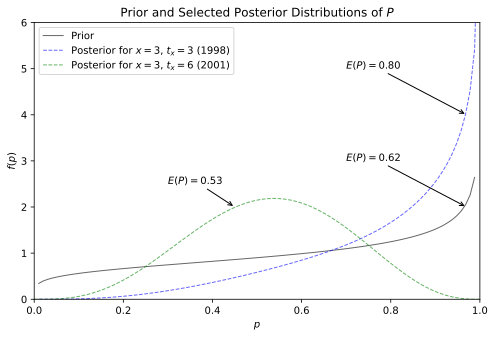

In [19]:
def annotate(ax, xy, xytext, str):
    return ax.annotate(str,
            xy=xy, xycoords='data',
            xytext=xytext, textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
        
fig, ax = plt.subplots(figsize=(8, 5))
p = np.linspace(beta_dist.ppf(0, alpha, beta),
                beta_dist.ppf(0.99, alpha, beta), 100)
ax.plot(p[1:-1], beta_dist.pdf(p[1:-1], alpha, beta), 'k', lw=1, alpha=0.6, label='Prior')
ax.plot(p[1:], marginal_posterior(3,3, p[1:]), 'b--', lw=1, alpha=0.6, label='Posterior for $x = 3$, $t_{x} = 3$ (1998)')
ax.plot(p, marginal_posterior(3,6, p), 'g--', lw=1, alpha=0.6, label='Posterior for $x = 3$, $t_{x} = 6$ (2001)')
ax.set_xlabel('$p$')
ax.set_ylabel('$f(p)$')
ax.set_title('Prior and Selected Posterior Distributions of $P$')
ax.legend()
ax.set_xlim(0,1)
ax.set_ylim(0,6)
annotate(ax, (0.45, 2), (0.3, 2.5), f"$E(P) = {compute_mean(3,6):.2f}$")
annotate(ax, (0.97, 4), (0.7, 5), f"$E(P) = {compute_mean(3,3):.2f}$")
annotate(ax, (0.97, 2), (0.7, 3), f"$E(P) = {beta_dist.stats(alpha, beta, moments='m'):.2f}$")

Text(0.1, 6.7, '$E(\\Theta) = 0.19$')

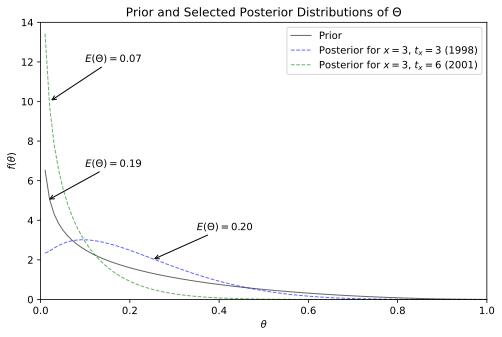

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
p = np.linspace(beta_dist.ppf(0, alpha, beta),
                beta_dist.ppf(0.99, alpha, beta), 100)
ax.plot(p, beta_dist.pdf(p, gamma, delta), 'k', lw=1, alpha=0.6, label='Prior')
ax.plot(p[1:], marginal_posterior(3,3, p[1:],theta=True), 'b--', lw=1, alpha=0.6, label='Posterior for $x = 3$, $t_{x} = 3$ (1998)')
ax.plot(p[1:], marginal_posterior(3,6, p[1:],theta=True), 'g--', lw=1, alpha=0.6, label='Posterior for $x = 3$, $t_{x} = 6$ (2001)')
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$f(\\theta)$')
ax.set_title('Prior and Selected Posterior Distributions of $\\Theta$')
ax.legend()
ax.set_xlim(0,1)
ax.set_ylim(0,14)
annotate(ax, (0.02, 10), (0.1, 12), f"$E(\\Theta) = {compute_mean(3,6,theta=True):.2f}$")
annotate(ax, (0.25, 2), (0.35, 3.5), f"$E(\\Theta) = {compute_mean(3,3,theta=True):.2f}$")
annotate(ax, (0.015, 5), (0.1, 6.7), f"$E(\\Theta) = {beta_dist.stats(gamma, delta, moments='m'):.2f}$")

### Conditional Penetration

Probability that a customer with purchase history ($x, t_{x}, n$) makes $x^{*}$ transactions in the interval $(n,n + n^{*}]$.

The probability that a customer is active in the 2002–2006 period ($n^{*} = 5$) is computed as $1-P(X(n,n+n^{*})=0 \mid x,t_{x}, n)$, where $x^{*}=0$, conditional on each of the 22 ($x,t_{x}$) patterns associated with $n = 6$.

In [21]:
n_star = 5
x_star = 0

A1 = beta_fn(alpha+p1x, beta+n-p1x)/B_alpha_beta * beta_fn(gamma, delta+n)/B_gamma_delta
B1 = np.where(x_star == 0, 1-(A1/L), 0)
A2 = comb(n_star, x_star) * beta_fn(alpha+p1x+x_star,beta+n-p1x+n_star-x_star)/B_alpha_beta * \
    beta_fn(gamma, delta+n+n_star)/beta_fn(gamma, delta)
i = np.arange(n_star).reshape(-1,1)
A2 += np.sum(comb(i,x_star)*beta_fn(alpha+p1x+x_star, beta+n-p1x+i-x_star)/B_alpha_beta * \
      beta_fn(gamma+1,delta+n+i)/B_gamma_delta, axis=0)

prob_alive_valid = 1 - (B1 + A2/L)

rfcalib_cross_tab(rfm_summary_calib.collect().hstack([pl.Series('Prob Alive in Valid Period', prob_alive_valid)]), 
                  values='Prob Alive in Valid Period',
                  title='Probability of Being Active in 2002–2006',
                  subtitle='as a Function of Recency and Frequency',
                  color_range=[0,1])

GT(_tbl_data=shape: (7, 8)
┌─────┬─────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ P1X ┆ 1995    ┆ 1996     ┆ 1997     ┆ 1998     ┆ 1999     ┆ 2000     ┆ 2001     │
│ --- ┆ ---     ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i8  ┆ f64     ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════╪═════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 0.04781 ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     │
│ 1   ┆ null    ┆ 0.046646 ┆ 0.171042 ┆ 0.323236 ┆ 0.456885 ┆ 0.55611  ┆ 0.624802 │
│ 2   ┆ null    ┆ null     ┆ 0.054125 ┆ 0.243589 ┆ 0.480536 ┆ 0.65567  ┆ 0.758258 │
│ 3   ┆ null    ┆ null     ┆ null     ┆ 0.085557 ┆ 0.395876 ┆ 0.690573 ┆ 0.837918 │
│ 4   ┆ null    ┆ null     ┆ null     ┆ null     ┆ 0.190054 ┆ 0.661572 ┆ 0.883403 │
│ 5   ┆ null    ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.509779 ┆ 0.908716 │
│ 6   ┆ null    ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.923191 │
└─────┴─────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x1473b1f50>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.stub: 2>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='1995', type=<ColInfoTypeEnum.default: 1>, column_label='1995', column_align='right', column_width=None), ColInfo(var='1996', type=<ColInfoTypeEnum.default: 1>, column_label='1996', column_align='right', column_width=None), ColInfo(var='1997', type=<ColInfoTypeEnum.default: 1>, column_label='1997', column_align='right', column_width=None), ColInfo(var='1998', type=<ColInfoTypeEnum.default: 1>, column_label='1998', column_align='right', column_width=None), ColInfo(var='1999', type=<ColInfoTypeEnum.default: 1>, column_label='1999', column_align='right', column_width=None), ColInfo(var='2000', type=<ColInfoTypeEnum.default: 1>, column_label='2000', column_align='right', column_width=None), ColInfo(var='2001', type=<ColInfoTypeEnum.default: 1>, column_label='2001', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x147423df0>, _spanners=Spanners([SpannerInfo(spanner_id='Year of last transaction', spanner_level=0, spanner_label='Year of last transaction', spanner_units=None, spanner_pattern=None, vars=['1995', '1996', '1997', '1998', '1999', '2000', '2001'], built=None)]), _heading=Heading(title='Probability of Being Active in 2002–2006', subtitle='as a Function of Recency and Frequency', preheader=None), _stubhead='P1X', _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='P1X', rows=[0]), grpname=None, colname='P1X', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#ffffff')]), StyleInfo(locname=LocBody(columns='P1X', rows=[1]), grpname=None, colname='P1X', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#663399')]), StyleInfo(locname=LocBody(columns='P1X', rows=[2]), grpname=None, colname='P1X', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[3]), grpname=None, colname='P1X', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[4]), grpname=None, colname='P1X', rownum=4, colnum=None, style

### Discounted Expected Residual Transactions (DERT)

Assuming that there are $k$ transaction opportunities per year, an annual discount rate of $r$ maps to a discount rate of $d = (1+r)^{1/k} −1$.

In [22]:
d = 0.1 # discount rate

A1 = beta_fn(alpha+p1x+1, beta+n-p1x)/B_alpha_beta * beta_fn(gamma, delta+n+1)/(B_gamma_delta * (1 + d))
A2 = hyp2f1(1, delta+n+1, gamma+delta+n+1, 1/(1+d)) / L
DERT = A1 * A2
DERT

array([5.9097465 , 5.08934409, 4.26894167, 3.44853925, 2.62813684,
       1.80773442, 2.85506485, 3.19696733, 2.84212677, 2.2725632 ,
       1.60898903, 0.91841206, 1.62927154, 1.6655478 , 1.32190306,
       0.35211974, 0.84428308, 0.93521536, 0.18759674, 0.49487548,
       0.13496128, 0.11475559])

### $S_{BB}$-G/B Model - Extending the Basic BG/BB Model

Generate two vectors of random numbers drawn from a normal distribution with mean zero and variance one:

In [23]:
# Set the seed for purposes of replication
# np.random.seed(100)

# Generate two vectors of random numbers drawn from a normal distribution with mean zero and variance one
# np.random.normal(loc=0.0, scale=1.0, size=(100_000, 2))
Z = np.random.randn(100_000, 2)
Z

array([[ 0.21392945, -0.21641572],
       [-0.48531923, -0.03308922],
       [-0.16357634, -2.16113407],
       ...,
       [ 1.06030607,  1.01775071],
       [-1.2271774 ,  1.25434601],
       [ 0.38056548, -0.88389789]], shape=(100000, 2))

This model sees us replacing the beta distributions for $p$ and $θ$ with logit-normal distributions. We will first consider the uncorrelated model.


In [24]:
# computes the value of the sample log-likelihood function for a given set of model parameters
def SbbGB_ll_uncorr(param):
    """
    evaluate the log-likelihood function for the uncorrelated S_BB-G/B model
    
    Parameters:
    param: array-like
        [μ_p, μ_θ, σ²_p, σ²_θ] for the logit-normal distributions
    """    
    # Part A - Initial calculations
    Mu = param[:2]
    Sigma = np.diag(param[2:4])
    Y = Z @ np.sqrt(Sigma)
    
    # Compute p and t for all samples at once
    p = 1 / (1 + np.exp(-(Y[:, 0] + Mu[0])))    # More numerically stable
    t = 1 / (1 + np.exp(-(Y[:, 1] + Mu[1])))
    
    # Part B - Vectorized likelihood computation
    ll = np.empty(len(p1x))
    
    # Pre-compute log terms for p and (1-p)
    log_p = np.log(p)
    log_1mp = np.log1p(-p)  # More accurate than np.log(1-p)
    log_t = np.log(t)
    log_1mt = np.log1p(-t)
    
    for i in range(len(p1x)):
        # Base term (j = n - t_x[i])
        base_term = (p1x[i] * log_p + 
                    (n - p1x[i]) * log_1mp + 
                    n * log_1mt)
        base_lik = np.exp(base_term)
        
        # Compute all j terms at once
        j_range = np.arange(n - t_x[i])
        
        # Broadcast shapes for vectorized computation
        j_terms = (p1x[i] * log_p[:, None] +
                  (t_x[i] - p1x[i] + j_range) * log_1mp[:, None] +
                  log_t[:, None] +
                  (t_x[i] + j_range) * log_1mt[:, None])
        
        # Sum all likelihoods
        total_lik = base_lik + np.sum(np.exp(j_terms), axis=1)
        
        # Compute log mean
        ll[i] = np.log(np.mean(total_lik))
    
    return -np.sum(ll * num_donors)

bnds = [[-10, 10], [-10, 10], [0, 10], [0, 10]]
res = minimize(SbbGB_ll_uncorr, x0=[0.1 for _ in range(4)], bounds=bnds)

display_markdown(f'''$\\mu_{{p}}$ = {res.x[0]:0.4f}

$\\mu_{{\\Theta}}$ = {res.x[1]:0.4f}

$\\sigma^{{2}}_{{P}}$ = {res.x[2]:0.4f}

$\\sigma^{{2}}_{{\\Theta}}$ = {res.x[3]:0.4f}

$LL$ = {res.fun:0.4f}''', raw=True)

$\mu_{p}$ = 0.7119

$\mu_{\Theta}$ = -1.9982

$\sigma^{2}_{P}$ = 3.1455

$\sigma^{2}_{\Theta}$ = 2.2037

$LL$ = 33226.4071

$E(P)$ = 0.6135

$var(P)$ = 0.0820

$E(\Theta)$ = 0.1891

$var(\Theta)$ = 0.0363

Text(0.5, 0, '$\\theta$')

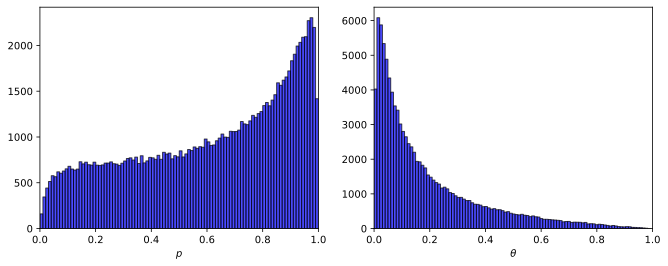

In [25]:
# Uncorrelated Moments
Mu = res.x[:2]
Sigma = np.diag(res.x[2:])
Y = Z @ np.sqrt(Sigma)

p = 1 / (1 + np.exp(-(Y[:, 0] + Mu[0])))
t = 1 / (1 + np.exp(-(Y[:, 1] + Mu[1])))

EP, ET = np.mean(p), np.mean(t)
VP, VT = np.mean(p*p) - EP**2, np.mean(t*t) - ET**2

display_markdown(f'''$E(P)$ = {EP:0.4f}

$var(P)$ = {VP:0.4f}

$E(\\Theta)$ = {ET:0.4f}

$var(\\Theta)$ = {VT:0.4f}''', raw=True)

fig, axes = plt.subplots(1, 2, figsize=(11,4))
axes[0].hist(p, bins=100, color='blue', edgecolor='black', alpha=0.7)
axes[0].set_xlim(0,1)
axes[0].set_xlabel("$p$")
axes[1].hist(t, bins=100,color='blue', edgecolor='black', alpha=0.7)
axes[1].set_xlim(0,1)
axes[1].set_xlabel("$\\theta$")

In [26]:
def SbbGB_ll_corr(param):
    """
    evaluate the log-likelihood function for the correlated S_BB-G/B model
    
    Parameters:
    param: array-like
        [μ_p, μ_θ, σ²_p, σ²_θ, σ_pθ] for the logit-normal distributions
    """    
    # Part A 
    Mu = param[:2]
    R = np.array([param[2:4], [0, param[4]]])
    Y = Z @ R
    
    p = 1 / (1 + np.exp(-(Y[:, 0] + Mu[0])))   
    t = 1 / (1 + np.exp(-(Y[:, 1] + Mu[1])))
    
    # Part B
    ll = np.empty(len(p1x))
    for i in range(len(p1x)):
        tmp_lik = p**p1x[i] * (1 - p)**(n - p1x[i]) * (1 - t)**n
        for j in range(n - t_x[i]):
            tmp_lik += p**p1x[i] * (1 - p)**(t_x[i] - p1x[i] + j) * t * (1 - t)**(t_x[i] + j)
        ll[i] = np.log(np.mean(tmp_lik))
    
    return -np.sum(ll * num_donors)

res = minimize(SbbGB_ll_corr, 
               x0=[0.1 for _ in range(5)], 
               bounds=[[-10, 10] for _ in range(5)])

display_markdown(f'''$\\mu_{{p}}$ = {res.x[0]:0.4f}

$\\mu_{{\\Theta}}$ = {res.x[1]:0.4f}

$\\sigma^{{2}}_{{P}}$ = {res.x[2]:0.4f}

$\\sigma^{{2}}_{{\\Theta}}$ = {res.x[3]:0.4f}

$\\sigma_{{P\\Theta}}$ = {res.x[4]:0.4f}

$LL$ = {res.fun:0.4f}''', raw=True)

$\mu_{p}$ = 1.1283

$\mu_{\Theta}$ = -2.1404

$\sigma^{2}_{P}$ = -1.9586

$\sigma^{2}_{\Theta}$ = -0.8970

$\sigma_{P\Theta}$ = 1.8061

$LL$ = 33210.4181

$E(P)$ = 0.6677

$var(P)$ = 0.0828

$E(\Theta)$ = 0.2107

$var(\Theta)$ = 0.0588

$corr(P,\Theta)$ = 0.3617

Text(0.5, 0, '$\\theta$')

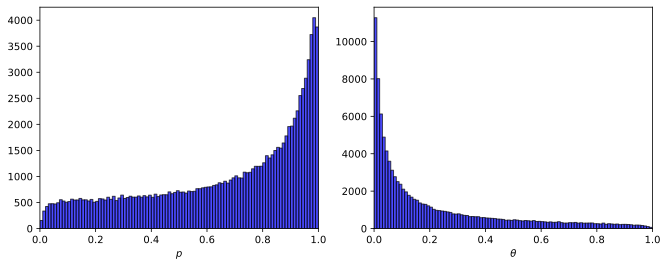

In [27]:
# Uncorrelated Moments
Mu = res.x[:2]
R = np.array([res.x[2:4], [0, res.x[4]]])
Y = Z @ R

p = 1 / (1 + np.exp(-(Y[:, 0] + Mu[0])))
t = 1 / (1 + np.exp(-(Y[:, 1] + Mu[1])))

EP, ET = np.mean(p), np.mean(t)
VP, VT = np.mean(p*p) - EP**2, np.mean(t*t) - ET**2
covPT = np.mean(p*t)-EP*ET 
corrPT = covPT/np.sqrt(VP*VT)

display_markdown(f'''$E(P)$ = {EP:0.4f}

$var(P)$ = {VP:0.4f}

$E(\\Theta)$ = {ET:0.4f}

$var(\\Theta)$ = {VT:0.4f}

$corr(P,\\Theta)$ = {corrPT:0.4f}''', raw=True)

fig, axes = plt.subplots(1, 2, figsize=(11,4))
axes[0].hist(p, bins=100, color='blue', edgecolor='black', alpha=0.7)
axes[0].set_xlim(0,1)
axes[0].set_xlabel("$p$")
axes[1].hist(t, bins=100,color='blue', edgecolor='black', alpha=0.7)
axes[1].set_xlim(0,1)
axes[1].set_xlabel("$\\theta$")

In [28]:
est_cum_repeat = np.mean(p*(1-t)/t - p*(1-t)**(n_trans[:,None]+1)/t, axis=1) * np.sum(rfm_array_calib[:,3])
est_yearly_repeat = np.diff(est_cum_repeat, prepend=0)

cum_repeat = cum_repeat.with_columns(
    pl.when(pl.col('Actual Vs Model') == 'Model')
    .then(pl.lit('BG/BB'))  
    .otherwise(pl.col('Actual Vs Model'))
    .alias('Actual Vs Model')
).vstack(pl.DataFrame({
    'Year': years[1:], 
    'Actual Vs Model': ['S_BB-G/B']*len(years[1:]), 
    'Repeat Trans': est_cum_repeat.flatten()})
)

yearly_repeat = yearly_repeat.with_columns(
    pl.when(pl.col('Actual Vs Model') == 'Model')
    .then(pl.lit('BG/BB'))  
    .otherwise(pl.col('Actual Vs Model'))
    .alias('Actual Vs Model')
).vstack(pl.DataFrame({
    'Year': years[1:], 
    'Actual Vs Model': ['S_BB-G/B']*len(years[1:]), 
    'Repeat Trans': est_yearly_repeat.flatten()})
)

In [29]:
(
    alt.Chart(cum_repeat).mark_line().encode(
        x=alt.X('Year', axis=alt.Axis(labelAngle=0)),
        y=alt.Y('Repeat Trans', title='Cumulative no. of repeat transactions'),
        strokeDash='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Cumulative Repeat Transactions'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [30]:
(
    alt.Chart(yearly_repeat).mark_line().encode(
        x=alt.X('Year', axis=alt.Axis(labelAngle=0)),
        y=alt.Y('Repeat Trans', title='No. of repeat transactions'),
        strokeDash='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Annual Repeat Transactions'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [31]:
PX = np.zeros(n+1)
for s in range(n+1):
    temp_px = comb(n,s) * p**s * (1-p)**(n-s) * (1-t)**n
    for j in range(s, n):
        temp_px += comb(j, s) * p**s * (1-p)**(j-s) * t * (1-t)**j
    PX[s] = np.mean(temp_px) 

actual_model_repeat_calib = actual_model_repeat_calib.with_columns(
    pl.when(pl.col('Actual Vs Estimated') == 'Model')
    .then(pl.lit('BG/BB'))  
    .otherwise(pl.col('Actual Vs Estimated'))
    .alias('Actual Vs Estimated')
).vstack(pl.DataFrame({
    'P1X': np.arange(n+1, dtype=np.int8), 
    'Actual Vs Estimated': ['S_BB-G/B']*(n+1), 
    'No of people': PX * np.sum(rfm_array_calib[:,3])})
)

(
    alt.Chart(actual_model_repeat_calib).mark_bar()
    .encode(x=alt.X('P1X:O', title='No. of repeat transactions', axis=alt.Axis(labelAngle=0)), 
         y=alt.Y('No of people:Q', title='No. of people'), 
         color='Actual Vs Estimated:N', 
         xOffset='Actual Vs Estimated')
    .properties(
        width=650,
        height=250,
        title='Predicted vs. Actual Frequency of Repeat Transactions (Calibration Period) in 1996 to 2001'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)   
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [32]:
n_star = 5
PXf = np.zeros(n_star+1)
for s in range(n_star+1):
    temp_px = (s==0) * (1-(1-t)**n) + comb(n_star,s) * p**s * (1-p)**(n_star-s) * (1-t)**(n+n_star)
    for j in range(s, n_star):
        temp_px += comb(j,s) * p**s * (1-p)**(j-s) * t * (1-t)**(n+j)
    PXf[s] = np.mean(temp_px) 

actual_model_repeat_valid = actual_model_repeat_valid.with_columns(
    pl.when(pl.col('Actual Vs Estimated') == 'Model')
    .then(pl.lit('BG/BB'))  
    .otherwise(pl.col('Actual Vs Estimated'))
    .alias('Actual Vs Estimated')
).vstack(pl.DataFrame({
    'P2X': np.arange(n_star+1, dtype=np.int8), 
    'Actual Vs Estimated': ['S_BB-G/B']*(n_star+1), 
    'No of people': PXf * np.sum(valid_repeat_count)})
)

(
    alt.Chart(actual_model_repeat_valid).mark_bar()
    .encode(x=alt.X('P2X:O', title='No. of repeat transactions', axis=alt.Axis(labelAngle=0)), 
         y=alt.Y('No of people:Q', title='No. of people'), 
         color='Actual Vs Estimated:N', 
         xOffset='Actual Vs Estimated')
    .properties(
        width=650,
        height=250,
        title='Predicted vs. Actual Frequency of Repeat Transactions (Validation Period) in 2002-2006'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)   
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [33]:
# Conditional Expectations
n_star = 5
CE = np.empty(len(p1x))
for i in range(len(p1x)):
    tmp_lik = p**p1x[i] * (1-p)**(n-p1x[i]) * (1-t)**n
    tmp_CE = (p*(1-t)/t - p*(1-t)**(n_star+1)/t) * tmp_lik
    for j in range(n - t_x[i]):
        tmp_lik += p**p1x[i]*(1-p)**(t_x[i]-p1x[i]+j) * t*(1-t)**(t_x[i]+j)
    CE[i] = np.mean(tmp_CE)/np.mean(tmp_lik)

In [34]:
ce_df_updated = ce_df.hstack([pl.Series('CE - S_BB-G/B', CE)])
rfcalib_cross_tab(ce_df_updated, 
                  values='CE - S_BB-G/B',
                  title='Expected Number of Repeat Transactions in 2002–2006',
                  subtitle='as a Function of Recency and Frequency, as Predicted by the S_{BB}-G/B Model',
                  color_range=[0,4])

GT(_tbl_data=shape: (7, 8)
┌─────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ P1X ┆ 1995     ┆ 1996     ┆ 1997     ┆ 1998     ┆ 1999     ┆ 2000     ┆ 2001     │
│ --- ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i8  ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 0.099492 ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     │
│ 1   ┆ null     ┆ 0.100021 ┆ 0.448613 ┆ 0.753995 ┆ 0.941966 ┆ 1.054849 ┆ 1.12546  │
│ 2   ┆ null     ┆ null     ┆ 0.124609 ┆ 0.667259 ┆ 1.22129  ┆ 1.530819 ┆ 1.685345 │
│ 3   ┆ null     ┆ null     ┆ null     ┆ 0.21929  ┆ 1.153562 ┆ 1.927618 ┆ 2.243703 │
│ 4   ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.561708 ┆ 2.116636 ┆ 2.779741 │
│ 5   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 1.771532 ┆ 3.257323 │
│ 6   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 3.596829 │
└─────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x147982c10>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.stub: 2>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='1995', type=<ColInfoTypeEnum.default: 1>, column_label='1995', column_align='right', column_width=None), ColInfo(var='1996', type=<ColInfoTypeEnum.default: 1>, column_label='1996', column_align='right', column_width=None), ColInfo(var='1997', type=<ColInfoTypeEnum.default: 1>, column_label='1997', column_align='right', column_width=None), ColInfo(var='1998', type=<ColInfoTypeEnum.default: 1>, column_label='1998', column_align='right', column_width=None), ColInfo(var='1999', type=<ColInfoTypeEnum.default: 1>, column_label='1999', column_align='right', column_width=None), ColInfo(var='2000', type=<ColInfoTypeEnum.default: 1>, column_label='2000', column_align='right', column_width=None), ColInfo(var='2001', type=<ColInfoTypeEnum.default: 1>, column_label='2001', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x147293650>, _spanners=Spanners([SpannerInfo(spanner_id='Year of last transaction', spanner_level=0, spanner_label='Year of last transaction', spanner_units=None, spanner_pattern=None, vars=['1995', '1996', '1997', '1998', '1999', '2000', '2001'], built=None)]), _heading=Heading(title='Expected Number of Repeat Transactions in 2002–2006', subtitle='as a Function of Recency and Frequency, as Predicted by the S_{BB}-G/B Model', preheader=None), _stubhead='P1X', _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='P1X', rows=[0]), grpname=None, colname='P1X', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#ffffff')]), StyleInfo(locname=LocBody(columns='P1X', rows=[1]), grpname=None, colname='P1X', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#d9cce6')]), StyleInfo(locname=LocBody(columns='P1X', rows=[2]), grpname=None, colname='P1X', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#b299cc')]), StyleInfo(locname=LocBody(columns='P1X', rows=[3]), grpname=None, colname='P1X', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#8c66b2')]), StyleInfo(locname=LocBody(columns='P1X', rows=[

In [35]:
exp_total = CE * num_donors

ce_df_mod = (
    ce_df
    .rename({'Exp Total': 'Exp Total - BG/BB', 'Conditional Expectation': 'CE - BG/BB'})
    .hstack([pl.Series('Exp Total - SbbG/B', exp_total)])
    .hstack([pl.Series('CE - SbbG/B', CE)])
)

# Expected total 2002-2006 donations by p1x / tx
est_ce_mat = ce_df_mod.sort('t_x').pivot(index='P1X', on='t_x', values='Exp Total - SbbG/B').sort('P1X').fill_null(0).to_numpy()[:,1:]

# CE by Frequency
est_ce_freq = np.sum(est_ce_mat, axis=1) / np.sum(num_donors_mat, axis=1)
ce_freq = (
    ce_freq
    .with_columns(pl.when(pl.col('Actual Vs Model') =='Model').then(pl.lit('BG/BB')).otherwise(pl.col('Actual Vs Model')).alias('Actual Vs Model'))
    .vstack(pl.DataFrame({'x': p1x_frequency, 'Actual Vs Model': ['S_BB-G/B'] * len(p1x_frequency), 'CE by Freq': est_ce_freq}))
)

# CE by Recency
est_ce_rec = np.sum(est_ce_mat, axis=0) / np.sum(num_donors_mat, axis=0)
ce_rec = (
    ce_rec
    .with_columns(pl.when(pl.col('Actual Vs Model')=='Model').then(pl.lit('BG/BB')).otherwise(pl.col('Actual Vs Model')).alias('Actual Vs Model'))
    .vstack(pl.DataFrame({'t_x': years[:len(p1x_frequency)], 'Actual Vs Model': ['S_BB-G/B'] * len(p1x_frequency), 'CE by Rec': est_ce_rec}).with_columns(pl.col('t_x').cast(pl.Int16)))
)

In [36]:
(
    alt.Chart(ce_freq).mark_line().encode(
        x=alt.X('x', title='No. of repeat transactions (1996-2001)', axis=alt.Axis(labelAngle=0, values=np.arange(7))),
        y=alt.Y('CE by Freq', title='No. of repeat transactions (2002–2006)'),
        strokeDash='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Conditional Expectations of Repeat Transactions in 2002–2006 as a Function of Frequency'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [37]:
(
    alt.Chart(ce_rec).mark_line().encode(
        x=alt.X('t_x', title='Year of last transaction', axis=alt.Axis(labelAngle=0, values=np.arange(1995, 2002, 1), format='.0f')),
        y=alt.Y('CE by Rec', title='No. of repeat transactions (2002–2006)'),
        strokeDash='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Conditional Expectations of Repeat Transactions in 2002–2006 as a Function of Recency'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [38]:
# P(Alive at n | p, t, x, t_x, n)
P_alive = np.empty(len(p1x))
for i in range(len(p1x)):
    A1 = p**p1x[i] * (1-p)**(n-p1x[i]) * (1-t)**n
    num = np.mean(A1)
    for j in range(n - t_x[i]):
        A1 += p**p1x[i]*(1-p)**(t_x[i]-p1x[i]+j) * t*(1-t)**(t_x[i]+j)
    P_alive[i] = num / np.mean(A1)

rfcalib_cross_tab(rfm_summary_calib.collect().hstack(pl.DataFrame({'P(Alive) - S_BB-G/B': P_alive})), 
                  values='P(Alive) - S_BB-G/B',
                  title='P(Alive in 2002) as a Function of Recency and Frequency',
                  color_range=[0,1])

GT(_tbl_data=shape: (7, 8)
┌─────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────┐
│ P1X ┆ 1995     ┆ 1996     ┆ 1997     ┆ 1998     ┆ 1999     ┆ 2000     ┆ 2001 │
│ --- ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---  │
│ i8  ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64  │
╞═════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════╡
│ 0   ┆ 0.165528 ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null │
│ 1   ┆ null     ┆ 0.088871 ┆ 0.398604 ┆ 0.669944 ┆ 0.836961 ┆ 0.93726  ┆ 1.0  │
│ 2   ┆ null     ┆ null     ┆ 0.073937 ┆ 0.395918 ┆ 0.724653 ┆ 0.908312 ┆ 1.0  │
│ 3   ┆ null     ┆ null     ┆ null     ┆ 0.097736 ┆ 0.514133 ┆ 0.859124 ┆ 1.0  │
│ 4   ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.202072 ┆ 0.761451 ┆ 1.0  │
│ 5   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.543861 ┆ 1.0  │
│ 6   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 1.0  │
└─────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────┘, _body=<great_tables._gt_data.Body object at 0x14794bf50>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.stub: 2>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='1995', type=<ColInfoTypeEnum.default: 1>, column_label='1995', column_align='right', column_width=None), ColInfo(var='1996', type=<ColInfoTypeEnum.default: 1>, column_label='1996', column_align='right', column_width=None), ColInfo(var='1997', type=<ColInfoTypeEnum.default: 1>, column_label='1997', column_align='right', column_width=None), ColInfo(var='1998', type=<ColInfoTypeEnum.default: 1>, column_label='1998', column_align='right', column_width=None), ColInfo(var='1999', type=<ColInfoTypeEnum.default: 1>, column_label='1999', column_align='right', column_width=None), ColInfo(var='2000', type=<ColInfoTypeEnum.default: 1>, column_label='2000', column_align='right', column_width=None), ColInfo(var='2001', type=<ColInfoTypeEnum.default: 1>, column_label='2001', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x1479b3e30>, _spanners=Spanners([SpannerInfo(spanner_id='Year of last transaction', spanner_level=0, spanner_label='Year of last transaction', spanner_units=None, spanner_pattern=None, vars=['1995', '1996', '1997', '1998', '1999', '2000', '2001'], built=None)]), _heading=Heading(title='P(Alive in 2002) as a Function of Recency and Frequency', subtitle=None, preheader=None), _stubhead='P1X', _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='P1X', rows=[0]), grpname=None, colname='P1X', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#ffffff')]), StyleInfo(locname=LocBody(columns='P1X', rows=[1]), grpname=None, colname='P1X', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#663399')]), StyleInfo(locname=LocBody(columns='P1X', rows=[2]), grpname=None, colname='P1X', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[3]), grpname=None, colname='P1X', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[4]), grpname=None, colname='P1X', rownum=4, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, alig

In [39]:
# P(Alive at n + 1 | p, t, x, t_x, n)
P_alive = np.empty(len(p1x))
for i in range(len(p1x)):
    num = p**p1x[i] * (1-p)**(n-p1x[i]) * (1-t)**(n+1)
    A1 = p**p1x[i] * (1-p)**(n-p1x[i]) * (1-t)**n
    for j in range(n - t_x[i]):
        A1 += p**p1x[i]*(1-p)**(t_x[i]-p1x[i]+j) * t*(1-t)**(t_x[i]+j)
    P_alive[i] = np.mean(num)/np.mean(A1)

rfcalib_cross_tab(rfm_summary_calib.collect().hstack(pl.DataFrame({'P(Alive) - S_BB-G/B': P_alive})), 
                  values='P(Alive) - S_BB-G/B',
                  title='P(Alive in 2002) as a Function of Recency and Frequency',
                  color_range=[0,1])

GT(_tbl_data=shape: (7, 8)
┌─────┬─────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ P1X ┆ 1995    ┆ 1996     ┆ 1997     ┆ 1998     ┆ 1999     ┆ 2000     ┆ 2001     │
│ --- ┆ ---     ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i8  ┆ f64     ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════╪═════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 0.16022 ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     │
│ 1   ┆ null    ┆ 0.085356 ┆ 0.382838 ┆ 0.643445 ┆ 0.803856 ┆ 0.900188 ┆ 0.960447 │
│ 2   ┆ null    ┆ null     ┆ 0.070569 ┆ 0.377883 ┆ 0.691644 ┆ 0.866937 ┆ 0.954448 │
│ 3   ┆ null    ┆ null     ┆ null     ┆ 0.092708 ┆ 0.487685 ┆ 0.814929 ┆ 0.948558 │
│ 4   ┆ null    ┆ null     ┆ null     ┆ null     ┆ 0.19033  ┆ 0.717204 ┆ 0.941892 │
│ 5   ┆ null    ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.507589 ┆ 0.933306 │
│ 6   ┆ null    ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.919813 │
└─────┴─────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x1479f0100>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.stub: 2>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='1995', type=<ColInfoTypeEnum.default: 1>, column_label='1995', column_align='right', column_width=None), ColInfo(var='1996', type=<ColInfoTypeEnum.default: 1>, column_label='1996', column_align='right', column_width=None), ColInfo(var='1997', type=<ColInfoTypeEnum.default: 1>, column_label='1997', column_align='right', column_width=None), ColInfo(var='1998', type=<ColInfoTypeEnum.default: 1>, column_label='1998', column_align='right', column_width=None), ColInfo(var='1999', type=<ColInfoTypeEnum.default: 1>, column_label='1999', column_align='right', column_width=None), ColInfo(var='2000', type=<ColInfoTypeEnum.default: 1>, column_label='2000', column_align='right', column_width=None), ColInfo(var='2001', type=<ColInfoTypeEnum.default: 1>, column_label='2001', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x147981fd0>, _spanners=Spanners([SpannerInfo(spanner_id='Year of last transaction', spanner_level=0, spanner_label='Year of last transaction', spanner_units=None, spanner_pattern=None, vars=['1995', '1996', '1997', '1998', '1999', '2000', '2001'], built=None)]), _heading=Heading(title='P(Alive in 2002) as a Function of Recency and Frequency', subtitle=None, preheader=None), _stubhead='P1X', _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='P1X', rows=[0]), grpname=None, colname='P1X', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#ffffff')]), StyleInfo(locname=LocBody(columns='P1X', rows=[1]), grpname=None, colname='P1X', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#663399')]), StyleInfo(locname=LocBody(columns='P1X', rows=[2]), grpname=None, colname='P1X', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[3]), grpname=None, colname='P1X', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[4]), grpname=None, colname='P1X', rownum=4, colnum=None, styles=[CellStyleText(colo

In [75]:
# Output array should be length n_star+1 (6), representing probabilities for each possible x*
PXf = np.empty((len(p1x), n_star+1))

# For each possible number of future transactions x*
for x_star in range(n_star + 1):
    # Calculate the mean probability across all customers
    
    # For each customer
    for i in range(len(p1x)):
        # Calculate P(alive at n) for this customer
        A1 = p**p1x[i] * (1 - p)**(n - p1x[i]) * (1 - t)**n
        numerator = np.mean(A1)
        for j in range(n - t_x[i]):
            A1 += p**p1x[i] * (1 - p)**(t_x[i] - p1x[i] + j) * t * (1 - t)**(t_x[i] + j)
        P_alive = numerator / np.mean(A1)
        
        # Calculate P(X(n,n+n*)=x*|p,θ,alive at n)
        temp_px = comb(n_star,x_star) * p**x_star * (1-p)**(n_star-x_star) * (1-t)**(n_star)
        for j in range(x_star, n_star):
            temp_px += comb(j,x_star) * p**x_star * (1-p)**(j-x_star) * t * (1-t)**j

        PXf[i, x_star] = (x_star==0)*(1 - P_alive) + np.mean(temp_px) * P_alive

In [92]:
rfcalib_cross_tab(rfm_summary_calib.collect().hstack(pl.DataFrame({'P(Alive) - S_BB-G/B': PXf[:,0]})), 
                  values='P(Alive) - S_BB-G/B',
                  title='P(Alive in 2002) as a Function of Recency and Frequency',
                  color_range=[0,1])

GT(_tbl_data=shape: (7, 8)
┌─────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ P1X ┆ 1995     ┆ 1996     ┆ 1997     ┆ 1998     ┆ 1999     ┆ 2000     ┆ 2001     │
│ --- ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i8  ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 0.887363 ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     │
│ 1   ┆ null     ┆ 0.939526 ┆ 0.728763 ┆ 0.544125 ┆ 0.430475 ┆ 0.362224 ┆ 0.319532 │
│ 2   ┆ null     ┆ null     ┆ 0.949688 ┆ 0.73059  ┆ 0.506897 ┆ 0.381923 ┆ 0.319532 │
│ 3   ┆ null     ┆ null     ┆ null     ┆ 0.933494 ┆ 0.650149 ┆ 0.415394 ┆ 0.319532 │
│ 4   ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.862497 ┆ 0.481857 ┆ 0.319532 │
│ 5   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.62992  ┆ 0.319532 │
│ 6   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.319532 │
└─────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x14738b070>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.stub: 2>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='1995', type=<ColInfoTypeEnum.default: 1>, column_label='1995', column_align='right', column_width=None), ColInfo(var='1996', type=<ColInfoTypeEnum.default: 1>, column_label='1996', column_align='right', column_width=None), ColInfo(var='1997', type=<ColInfoTypeEnum.default: 1>, column_label='1997', column_align='right', column_width=None), ColInfo(var='1998', type=<ColInfoTypeEnum.default: 1>, column_label='1998', column_align='right', column_width=None), ColInfo(var='1999', type=<ColInfoTypeEnum.default: 1>, column_label='1999', column_align='right', column_width=None), ColInfo(var='2000', type=<ColInfoTypeEnum.default: 1>, column_label='2000', column_align='right', column_width=None), ColInfo(var='2001', type=<ColInfoTypeEnum.default: 1>, column_label='2001', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x147cd7ef0>, _spanners=Spanners([SpannerInfo(spanner_id='Year of last transaction', spanner_level=0, spanner_label='Year of last transaction', spanner_units=None, spanner_pattern=None, vars=['1995', '1996', '1997', '1998', '1999', '2000', '2001'], built=None)]), _heading=Heading(title='P(Alive in 2002) as a Function of Recency and Frequency', subtitle=None, preheader=None), _stubhead='P1X', _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='P1X', rows=[0]), grpname=None, colname='P1X', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#ffffff')]), StyleInfo(locname=LocBody(columns='P1X', rows=[1]), grpname=None, colname='P1X', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#663399')]), StyleInfo(locname=LocBody(columns='P1X', rows=[2]), grpname=None, colname='P1X', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[3]), grpname=None, colname='P1X', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[4]), grpname=None, colname='P1X', rownum=4, colnum=None, styles=[CellS

In [ ]:
# DERT
d = 0.1 # discount rate
DERT_SbbGB = np.empty(len(p1x))
for i in range(len(p1x)):
    A1 = p**(p1x[i]+1) * (1-p)**(n-p1x[i]) * (1-t)**(n+1) / (d + t)
    tmp_lik = p**p1x[i] * (1-p)**(n-p1x[i]) * (1-t)**n
    for j in range(n - t_x[i]):
        tmp_lik += p**p1x[i]*(1-p)**(t_x[i]-p1x[i]+j) * t*(1-t)**(t_x[i]+j)
    DERT_SbbGB[i] = np.mean(A1) * (1 / np.mean(tmp_lik))

DERT_SbbGB